In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# For the models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM
from sklearn.svm import SVC

# For evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


2024-09-29 21:41:54.939808: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-29 21:41:55.055129: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-29 21:41:56.431909: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-29 21:41:56.957027: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-29 21:41:57.463573: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

# Load and Preprocess

In [3]:
import pandas as pd
import numpy as np
# Load datasets
anomaly_df = pd.read_csv("/home/yadasa/Desktop/WAF/WAF_with_ml/data/anomaliousTraffic.csv")
normal_df = pd.read_csv("/home/yadasa/Desktop/WAF/WAF_with_ml/data/normalTraffic.csv")
web_traffic_df = pd.read_csv("/home/yadasa/Desktop/WAF/WAF_with_ml/data/web_traffic.csv")

/tmp/ipykernel_232615/2339468034.py:4: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  anomaly_df = pd.read_csv("/home/yadasa/Desktop/WAF/WAF_with_ml/data/anomaliousTraffic.csv")
/tmp/ipykernel_232615/2339468034.py:5: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  normal_df = pd.read_csv("/home/yadasa/Desktop/WAF/WAF_with_ml/data/normalTraffic.csv")
/tmp/ipykernel_232615/2339468034.py:6: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  web_traffic_df = pd.read_csv("/home/yadasa/Desktop/WAF/WAF_with_ml/data/web_traffic.csv")


In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split


# Combine datasets
web_df = pd.concat([anomaly_df, normal_df, web_traffic_df], ignore_index=True)

# Handle missing values
web_df.fillna(0, inplace=True)

# Convert contentLength to numeric (cleaning step)
web_df['contentLength'] = pd.to_numeric(web_df['contentLength'], errors='coerce')
web_df.fillna(0, inplace=True)

# Define features and target
features = ['method', 'url', 'protocol', 'userAgent', 'pragma', 'cacheControl', 'accept', 
            'acceptEncoding', 'acceptCharset', 'acceptLanguage', 'host', 'connection', 
            'contentLength', 'payload']
target = 'label'

# Convert target variable to numeric
label_encoder = LabelEncoder()
web_df[target] = label_encoder.fit_transform(web_df[target])

# Categorical columns
categorical_cols = ['method', 'url', 'protocol', 'userAgent', 'pragma', 'cacheControl', 
                    'accept', 'acceptEncoding', 'acceptCharset', 'acceptLanguage', 
                    'host', 'connection', 'payload']

# Convert mixed-type columns to strings to ensure uniform data types
for col in categorical_cols:
    web_df[col] = web_df[col].astype(str)  # Convert to string type

# Label encode categorical features
for col in categorical_cols:
    web_df[col] = label_encoder.fit_transform(web_df[col])

# Scale the numerical data
scaler = StandardScaler()
web_df['contentLength'] = scaler.fit_transform(web_df[['contentLength']])

# Train-test split (80:20)
X = web_df[features]
y = web_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:

# 1. Total Amount of Data
total_data = web_df.shape[0]
print(f"Total amount of data: {total_data} instances")

# 2. Labels
labels = web_df['label'].unique()
print(f"Unique labels in the dataset: {labels}")

# 3. Number of Instances per Class
instances_per_class = web_df['label'].value_counts()
print("Number of instances per class:")
print(instances_per_class)

# 4. Features Overview
features_info = web_df.dtypes
print("Features overview:")
print(features_info)


Total amount of data: 447170 instances
Unique labels in the dataset: [0 1]
Number of instances per class:
label
0    239170
1    208000
Name: count, dtype: int64
Features overview:
index               int64
method              int64
url                 int64
protocol            int64
userAgent           int64
pragma              int64
cacheControl        int64
accept              int64
acceptEncoding      int64
acceptCharset       int64
acceptLanguage      int64
host                int64
connection          int64
contentLength     float64
contentType        object
cookie             object
payload             int64
label               int64
dtype: object


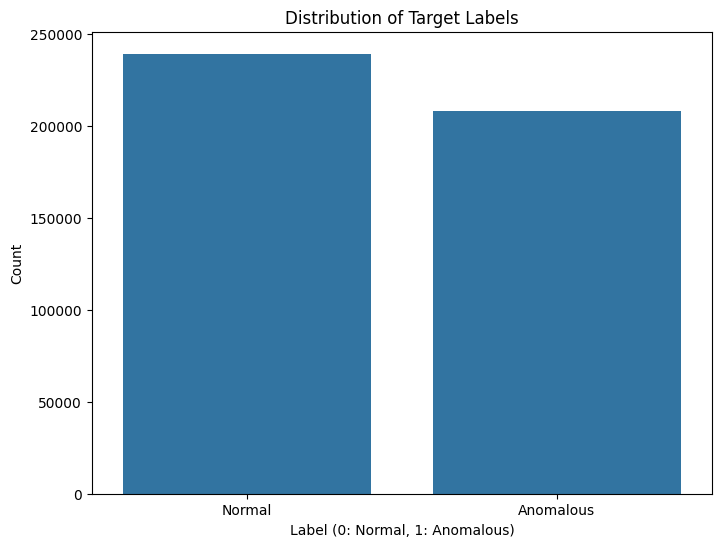

In [12]:
# Plotting the distribution of target labels
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=web_df)
plt.title('Distribution of Target Labels')
plt.xlabel('Label (0: Normal, 1: Anomalous)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Normal', 'Anomalous'])
plt.show()


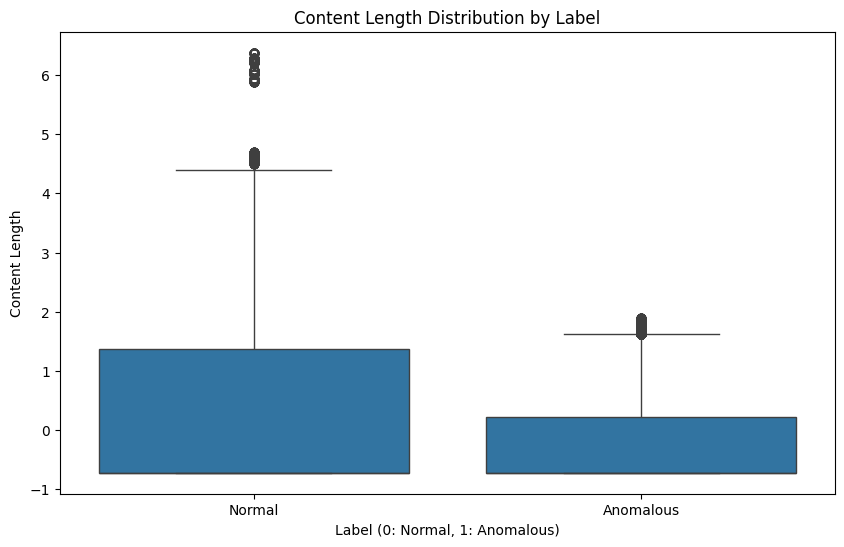

In [13]:
# Summary statistics of numerical features
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='contentLength', data=web_df)
plt.title('Content Length Distribution by Label')
plt.xlabel('Label (0: Normal, 1: Anomalous)')
plt.ylabel('Content Length')
plt.xticks(ticks=[0, 1], labels=['Normal', 'Anomalous'])
plt.show()


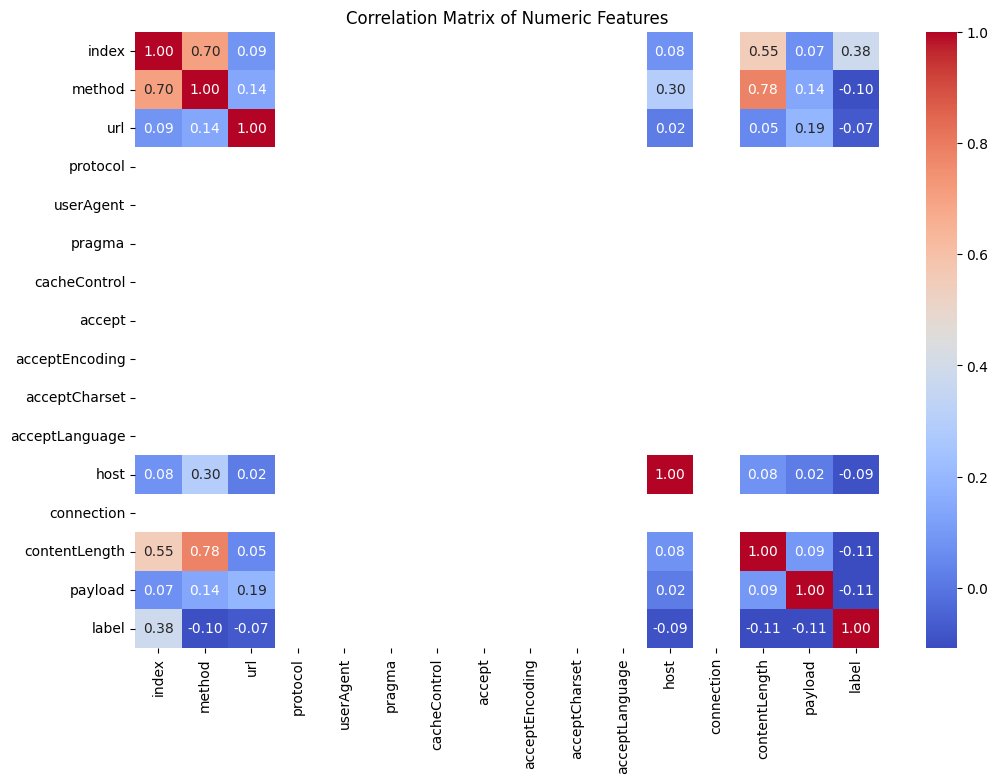

In [15]:
# Select only numeric columns
numeric_columns = web_df.select_dtypes(include=[np.number])

# Calculate the correlation matrix for numeric columns
correlation_matrix = numeric_columns.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric Features')
plt.show()


#  Reshape Data for CNN and LSTM

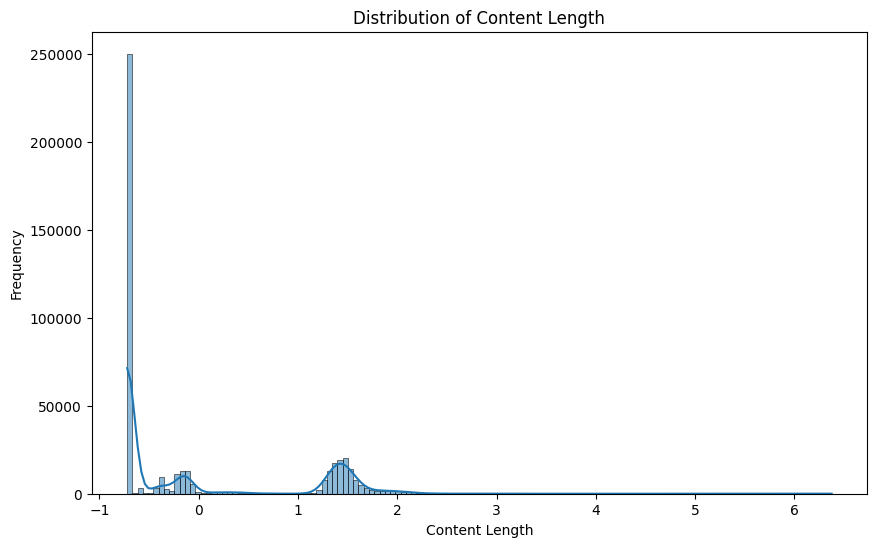

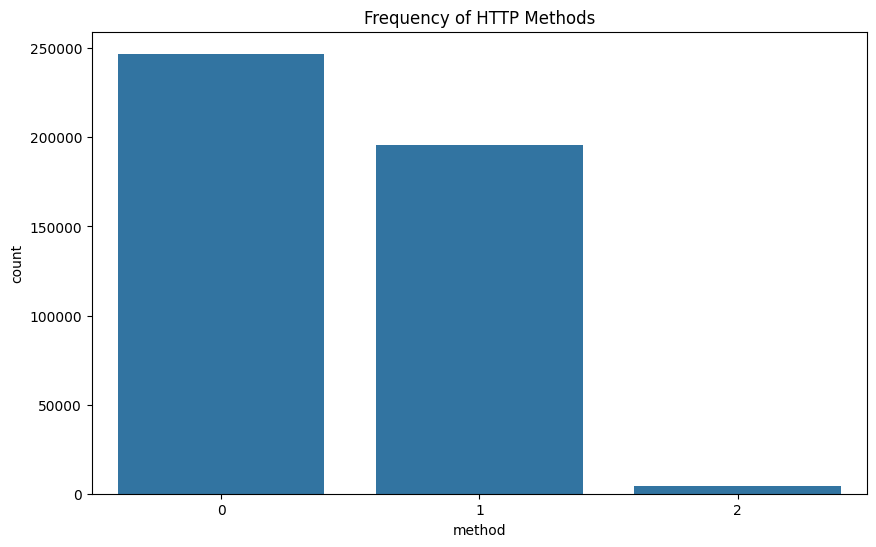

In [7]:
# EDA - Visualizing the Distribution of Content Length
plt.figure(figsize=(10, 6))
sns.histplot(web_df['contentLength'], kde=True)
plt.title('Distribution of Content Length')
plt.xlabel('Content Length')
plt.ylabel('Frequency')
plt.show()

# EDA - Visualizing HTTP Methods
plt.figure(figsize=(10, 6))
sns.countplot(x='method', data=web_df)
plt.title('Frequency of HTTP Methods')
plt.show()


In [17]:
# Reshape data to 3D for CNN and LSTM
X_train_reshaped = np.expand_dims(X_train, axis=2)
X_test_reshaped = np.expand_dims(X_test, axis=2)


# CNN for Feature Extraction

In [18]:

cnn_model = Sequential()

# Add Conv1D layer
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())

# Output layer: one neuron with sigmoid activation for binary classification
cnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model (binary_crossentropy for binary classification)
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN model
cnn_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Extract CNN features for both training and test sets
X_train_cnn_features = cnn_model.predict(X_train_reshaped)
X_test_cnn_features = cnn_model.predict(X_test_reshaped)



/home/yadasa/Desktop/WAF/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.5326 - loss: 2.6265 - val_accuracy: 0.5716 - val_loss: 0.8568
Epoch 2/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.5465 - loss: 2.0898 - val_accuracy: 0.5181 - val_loss: 0.7660
Epoch 3/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.5496 - loss: 1.6909 - val_accuracy: 0.5631 - val_loss: 0.7177
Epoch 4/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.5508 - loss: 1.3178 - val_accuracy: 0.4770 - val_loss: 1.2852
Epoch 5/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.5550 - loss: 1.1380 - val_accuracy: 0.6013 - val_loss: 0.7712
Epoch 6/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.5553 - loss: 1.0057 - val_accuracy: 0.6023 - val_loss: 0.6521
Epoch 7/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.5578 - loss: 0.9720 - val_accuracy: 0.6019 - val_loss: 0.9271
Epoch 8/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.5667 - loss: 0

# LSTM for Temporal Dependencies

In [21]:

lstm_model = Sequential()

# Add LSTM layers
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_cnn_features.shape[1], 1)))
lstm_model.add(LSTM(units=50))

# Add a final Dense layer with a single neuron and sigmoid activation for binary classification
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the LSTM model for binary classification
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Reshape CNN features for LSTM
X_train_lstm_input = np.expand_dims(X_train_cnn_features, axis=2)
X_test_lstm_input = np.expand_dims(X_test_cnn_features, axis=2)

# Train the LSTM model
lstm_model.fit(X_train_lstm_input, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Extract LSTM features
X_train_lstm_features = lstm_model.predict(X_train_lstm_input)
X_test_lstm_features = lstm_model.predict(X_test_lstm_input)



Epoch 1/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.6032 - loss: 0.6539 - val_accuracy: 0.6123 - val_loss: 0.6488
Epoch 2/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6092 - loss: 0.6506 - val_accuracy: 0.6107 - val_loss: 0.6480
Epoch 3/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.6083 - loss: 0.6501 - val_accuracy: 0.6110 - val_loss: 0.6479
Epoch 4/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6091 - loss: 0.6497 - val_accuracy: 0.6110 - val_loss: 0.6478
Epoch 5/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6083 - loss: 0.6502 - val_accuracy: 0.6106 - val_loss: 0.6481
Epoch 6/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6106 - loss: 0.6490 - val_accuracy: 0.6106 - val_loss: 0.6478
Epoch 7/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6091 - loss: 0.6503 - val_accuracy: 0.6127 - val_loss: 0.6479
Epoch 8/10
8944/8944 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6084 - loss: 0

# Dataset Description 

In [13]:


# 1. Get Column Names for Each Dataset
print("Anomalous Traffic Columns:", anomaly_df.columns)
print("Normal Traffic Columns:", normal_df.columns)
print("Web Traffic Columns:", web_traffic_df.columns)
# 4. Get Column Names for the Merged Dataset
print("\nMerged Dataset Columns:", merged_df.columns)

# 2. Check for Missing Values in Each Dataset
print("\nMissing Values in Anomalous Traffic Dataset:\n", anomaly_df.isnull().sum())


Anomalous Traffic Columns: Index(['index', 'method', 'url', 'protocol', 'userAgent', 'pragma',
       'cacheControl', 'accept', 'acceptEncoding', 'acceptCharset',
       'acceptLanguage', 'host', 'connection', 'contentLength', 'contentType',
       'cookie', 'payload', 'label'],
      dtype='object')
Normal Traffic Columns: Index(['index', 'method', 'url', 'protocol', 'userAgent', 'pragma',
       'cacheControl', 'accept', 'acceptEncoding', 'acceptCharset',
       'acceptLanguage', 'host', 'connection', 'contentLength', 'contentType',
       'cookie', 'payload', 'label'],
      dtype='object')
Web Traffic Columns: Index(['index', 'method', 'url', 'protocol', 'userAgent', 'pragma',
       'cacheControl', 'accept', 'acceptEncoding', 'acceptCharset',
       'acceptLanguage', 'host', 'connection', 'contentLength', 'contentType',
       'cookie', 'payload', 'label'],
      dtype='object')

Merged Dataset Columns: Index(['index', 'method', 'url', 'protocol', 'userAgent', 'pragma',
       'ca

In [10]:
print("\nMissing Values in Normal Traffic Dataset:\n", normal_df.isnull().sum())



Missing Values in Normal Traffic Dataset:
 index                 0
method                0
url                   0
protocol              0
userAgent             0
pragma                0
cacheControl          0
accept                0
acceptEncoding        0
acceptCharset         0
acceptLanguage        0
host                  0
connection            0
contentLength     62000
contentType       62000
cookie                0
payload           20000
label                 0
dtype: int64


In [16]:
normal_df.head()

,index,method,url,protocol,userAgent,pragma,cacheControl,accept,acceptEncoding,acceptCharset,acceptLanguage,host,connection,contentLength,contentType,cookie,payload,label
0,0,GET,http://localhost:8080/tienda1/index.jsp,HTTP/1.1,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,close,NaN,NaN,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,NaN,norm
1,1,GET,http://localhost:8080/tienda1/publico/anadir.jsp,HTTP/1.1,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,close,NaN,NaN,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,id=3,norm
2,1,GET,http://localhost:8080/tienda1/publico/anadir.jsp,HTTP/1.1,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,close,NaN,NaN,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,nombre=Vino+Rioja,norm
3,1,GET,http://localhost:8080/tienda1/publico/anadir.jsp,HTTP/1.1,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,close,NaN,NaN,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,precio=100,norm
4,1,GET,http://localhost:8080/tienda1/publico/anadir.jsp,HTTP/1.1,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,close,NaN,NaN,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,cantidad=55,norm


In [19]:
print("\nMissing Values in anomaly Traffic Dataset:\n", anomaly_df.isnull().sum())


Missing Values in anomaly Traffic Dataset:
 index                 0
method                0
url                   0
protocol              0
userAgent             0
pragma                0
cacheControl          0
accept                0
acceptEncoding        0
acceptCharset         0
acceptLanguage        0
host                  0
connection            0
contentLength     61450
contentType       61450
cookie                0
payload            5491
label                 0
dtype: int64


In [17]:
anomaly_df.head()

,index,method,url,protocol,userAgent,pragma,cacheControl,accept,acceptEncoding,acceptCharset,acceptLanguage,host,connection,contentLength,contentType,cookie,payload,label
0,0,GET,http://localhost:8080/tienda1/publico/anadir.jsp,HTTP/1.1,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,close,NaN,NaN,JSESSIONID=B92A8B48B9008CD29F622A994E0F650D,id=2,anom
1,0,GET,http://localhost:8080/tienda1/publico/anadir.jsp,HTTP/1.1,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,close,NaN,NaN,JSESSIONID=B92A8B48B9008CD29F622A994E0F650D,nombre=Jam%F3n+Ib%E9rico,anom
2,0,GET,http://localhost:8080/tienda1/publico/anadir.jsp,HTTP/1.1,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,close,NaN,NaN,JSESSIONID=B92A8B48B9008CD29F622A994E0F650D,precio=85,anom
3,0,GET,http://localhost:8080/tienda1/publico/anadir.jsp,HTTP/1.1,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,close,NaN,NaN,JSESSIONID=B92A8B48B9008CD29F622A994E0F650D,cantidad=%27%3B+DROP+TABLE+usuarios%3B+SELECT+...,anom
4,0,GET,http://localhost:8080/tienda1/publico/anadir.jsp,HTTP/1.1,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,close,NaN,NaN,JSESSIONID=B92A8B48B9008CD29F622A994E0F650D,B1=A%F1adir+al+carrito,anom


In [11]:
print("\nMissing Values in Web Traffic Dataset:\n", web_traffic_df.isnull().sum())

# 3. Merge the datasets
merged_df = pd.concat([anomaly_df, normal_df, web_traffic_df], ignore_index=True)


Missing Values in Web Traffic Dataset:
 index                  0
method                 0
url                    0
protocol               0
userAgent              0
pragma                 0
cacheControl           0
accept                 0
acceptEncoding         0
acceptCharset          0
acceptLanguage         0
host                   0
connection             0
contentLength     123450
contentType       123450
cookie                 0
payload            25491
label                  0
dtype: int64


In [18]:
merged_df.head()

,index,method,url,protocol,userAgent,pragma,cacheControl,accept,acceptEncoding,acceptCharset,acceptLanguage,host,connection,contentLength,contentType,cookie,payload,label
0,0,GET,http://localhost:8080/tienda1/publico/anadir.jsp,HTTP/1.1,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,close,NaN,NaN,JSESSIONID=B92A8B48B9008CD29F622A994E0F650D,id=2,anom
1,0,GET,http://localhost:8080/tienda1/publico/anadir.jsp,HTTP/1.1,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,close,NaN,NaN,JSESSIONID=B92A8B48B9008CD29F622A994E0F650D,nombre=Jam%F3n+Ib%E9rico,anom
2,0,GET,http://localhost:8080/tienda1/publico/anadir.jsp,HTTP/1.1,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,close,NaN,NaN,JSESSIONID=B92A8B48B9008CD29F622A994E0F650D,precio=85,anom
3,0,GET,http://localhost:8080/tienda1/publico/anadir.jsp,HTTP/1.1,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,close,NaN,NaN,JSESSIONID=B92A8B48B9008CD29F622A994E0F650D,cantidad=%27%3B+DROP+TABLE+usuarios%3B+SELECT+...,anom
4,0,GET,http://localhost:8080/tienda1/publico/anadir.jsp,HTTP/1.1,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,close,NaN,NaN,JSESSIONID=B92A8B48B9008CD29F622A994E0F650D,B1=A%F1adir+al+carrito,anom


In [12]:

# 5. Check for Missing Values in Merged Dataset
print("\nMissing Values in Merged Dataset:\n", merged_df.isnull().sum())


Merged Dataset Columns: Index(['index', 'method', 'url', 'protocol', 'userAgent', 'pragma',
       'cacheControl', 'accept', 'acceptEncoding', 'acceptCharset',
       'acceptLanguage', 'host', 'connection', 'contentLength', 'contentType',
       'cookie', 'payload', 'label'],
      dtype='object')

Missing Values in Merged Dataset:
 index                  0
method                 0
url                    0
protocol               0
userAgent              0
pragma                 0
cacheControl           0
accept                 0
acceptEncoding         0
acceptCharset          0
acceptLanguage         0
host                   0
connection             0
contentLength     246900
contentType       246900
cookie                 0
payload            50982
label                  0
dtype: int64


In [20]:
# 1. Get Column Names for Each Dataset
anomaly_columns = anomaly_df.columns.tolist()
normal_columns = normal_df.columns.tolist()
web_traffic_columns = web_traffic_df.columns.tolist()
merged_columns = merged_df.columns.tolist()

# 2. Check for Missing Values in Each Dataset
anomaly_missing = anomaly_df.isnull().sum()
normal_missing = normal_df.isnull().sum()
web_traffic_missing = web_traffic_df.isnull().sum()

# 3. Total amount of data and unique labels
total_data = merged_df.shape[0]
unique_labels = merged_df['label'].unique()
instances_per_class = merged_df['label'].value_counts()

# 4. Features overview
features_overview = merged_df.dtypes

# Create a summary DataFrame for each dataset
def create_summary_df(columns, missing):
    summary = pd.DataFrame({
        'Column Name': columns,
        'Data Type': [anomaly_df[col].dtype if col in anomaly_df.columns else normal_df[col].dtype for col in columns],
        'Missing Values': missing
    })
    return summary

# Summaries
anomaly_summary = create_summary_df(anomaly_columns, anomaly_missing)
normal_summary = create_summary_df(normal_columns, normal_missing)
web_traffic_summary = create_summary_df(web_traffic_columns, web_traffic_missing)
merged_summary = create_summary_df(merged_columns, merged_df.isnull().sum())

# Displaying Results
print(f"Total amount of data: {total_data} instances")
print(f"Unique labels in the dataset: {unique_labels}")
print("Number of instances per class:\n", instances_per_class)
print("Features overview:\n", features_overview)

print("\nMissing Values in Anomalous Traffic Dataset:\n", anomaly_summary)
print("\nMissing Values in Normal Traffic Dataset:\n", normal_summary)
print("\nMissing Values in Web Traffic Dataset:\n", web_traffic_summary)
print("\nMerged Dataset Summary:\n", merged_summary)

Total amount of data: 447170 instances
Unique labels in the dataset: ['anom' 'norm']
Number of instances per class:
 label
anom    239170
norm    208000
Name: count, dtype: int64
Features overview:
 index               int64
method             object
url                object
protocol           object
userAgent          object
pragma             object
cacheControl       object
accept             object
acceptEncoding     object
acceptCharset      object
acceptLanguage     object
host               object
connection         object
contentLength     float64
contentType        object
cookie             object
payload            object
label              object
dtype: object

Missing Values in Anomalous Traffic Dataset:
                    Column Name Data Type  Missing Values
index                    index     int64               0
method                  method    object               0
url                        url    object               0
protocol              protocol    object    

In [33]:


# 1. Get Column Names for Each Dataset
anomaly_columns = anomaly_df.columns.tolist()
normal_columns = normal_df.columns.tolist()
web_traffic_columns = web_traffic_df.columns.tolist()
merged_columns = merged_df.columns.tolist()

# 2. Check for Missing Values in Each Dataset
anomaly_missing = anomaly_df.isnull().sum()
normal_missing = normal_df.isnull().sum()
web_traffic_missing = web_traffic_df.isnull().sum()

# 3. Total amount of data and unique labels
total_data = merged_df.shape[0]
unique_labels = merged_df['label'].unique()
instances_per_class = merged_df['label'].value_counts()

# 4. Features overview
features_overview = merged_df.dtypes

# Create a summary DataFrame for each dataset
def create_summary_df(columns, missing):
    summary = pd.DataFrame({
        'Column Name': columns,
        'Data Type': [anomaly_df[col].dtype if col in anomaly_df.columns else normal_df[col].dtype for col in columns],
        'Missing Values': missing
    })
    return summary

# Summaries
anomaly_summary = create_summary_df(anomaly_columns, anomaly_missing)
normal_summary = create_summary_df(normal_columns, normal_missing)
web_traffic_summary = create_summary_df(web_traffic_columns, web_traffic_missing)
merged_summary = create_summary_df(merged_columns, merged_df.isnull().sum())

# Displaying Results in Tables
print(f"Total amount of data: {total_data} instances")
print(f"Unique labels in the dataset: {unique_labels}")
print("Number of instances per class:\n", instances_per_class)

Total amount of data: 447170 instances
Unique labels in the dataset: ['anom' 'norm']
Number of instances per class:
 label
anom    239170
norm    208000
Name: count, dtype: int64


In [24]:
# Display the feature overview
features_overview_df = pd.DataFrame(features_overview, columns=['Data Type']).reset_index()
features_overview_df.columns = ['Feature', 'Data Type']
print("\nFeatures Overview:\n", features_overview_df)


Features Overview:
            Feature Data Type
0            index     int64
1           method    object
2              url    object
3         protocol    object
4        userAgent    object
5           pragma    object
6     cacheControl    object
7           accept    object
8   acceptEncoding    object
9    acceptCharset    object
10  acceptLanguage    object
11            host    object
12      connection    object
13   contentLength   float64
14     contentType    object
15          cookie    object
16         payload    object
17           label    object


In [27]:
# Display summaries in tabular format
print("\nMissing Values in Anomalous Traffic Dataset:\n", anomaly_summary)


Missing Values in Anomalous Traffic Dataset:
                    Column Name Data Type  Missing Values
index                    index     int64               0
method                  method    object               0
url                        url    object               0
protocol              protocol    object               0
userAgent            userAgent    object               0
pragma                  pragma    object               0
cacheControl      cacheControl    object               0
accept                  accept    object               0
acceptEncoding  acceptEncoding    object               0
acceptCharset    acceptCharset    object               0
acceptLanguage  acceptLanguage    object               0
host                      host    object               0
connection          connection    object               0
contentLength    contentLength   float64           61450
contentType        contentType    object           61450
cookie                  cookie    object 

In [28]:
print("\nMissing Values in Normal Traffic Dataset:\n", normal_summary)


Missing Values in Normal Traffic Dataset:
                    Column Name Data Type  Missing Values
index                    index     int64               0
method                  method    object               0
url                        url    object               0
protocol              protocol    object               0
userAgent            userAgent    object               0
pragma                  pragma    object               0
cacheControl      cacheControl    object               0
accept                  accept    object               0
acceptEncoding  acceptEncoding    object               0
acceptCharset    acceptCharset    object               0
acceptLanguage  acceptLanguage    object               0
host                      host    object               0
connection          connection    object               0
contentLength    contentLength   float64           62000
contentType        contentType    object           62000
cookie                  cookie    object    

In [29]:
print("\nMissing Values in Web Traffic Dataset:\n", web_traffic_summary)


Missing Values in Web Traffic Dataset:
                    Column Name Data Type  Missing Values
index                    index     int64               0
method                  method    object               0
url                        url    object               0
protocol              protocol    object               0
userAgent            userAgent    object               0
pragma                  pragma    object               0
cacheControl      cacheControl    object               0
accept                  accept    object               0
acceptEncoding  acceptEncoding    object               0
acceptCharset    acceptCharset    object               0
acceptLanguage  acceptLanguage    object               0
host                      host    object               0
connection          connection    object               0
contentLength    contentLength   float64          123450
contentType        contentType    object          123450
cookie                  cookie    object       

In [30]:
print("\nMerged Dataset Summary:\n", merged_summary)


Merged Dataset Summary:
                    Column Name Data Type  Missing Values
index                    index     int64               0
method                  method    object               0
url                        url    object               0
protocol              protocol    object               0
userAgent            userAgent    object               0
pragma                  pragma    object               0
cacheControl      cacheControl    object               0
accept                  accept    object               0
acceptEncoding  acceptEncoding    object               0
acceptCharset    acceptCharset    object               0
acceptLanguage  acceptLanguage    object               0
host                      host    object               0
connection          connection    object               0
contentLength    contentLength   float64          246900
contentType        contentType    object          246900
cookie                  cookie    object               0
paylo

# SVM for Final Classification

In [22]:
# Initialize SVM model
svm_model = SVC(kernel='rbf', C=1, gamma=0.1)

# Train the SVM model on LSTM features
svm_model.fit(X_train_lstm_features, y_train)

# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test_lstm_features)


# Model Evaluation

Accuracy: 60.83%
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.98      0.73     47929
           1       0.87      0.18      0.30     41505

    accuracy                           0.61     89434
   macro avg       0.73      0.58      0.52     89434
weighted avg       0.72      0.61      0.53     89434

Confusion Matrix:
[[46806  1123]
 [33910  7595]]


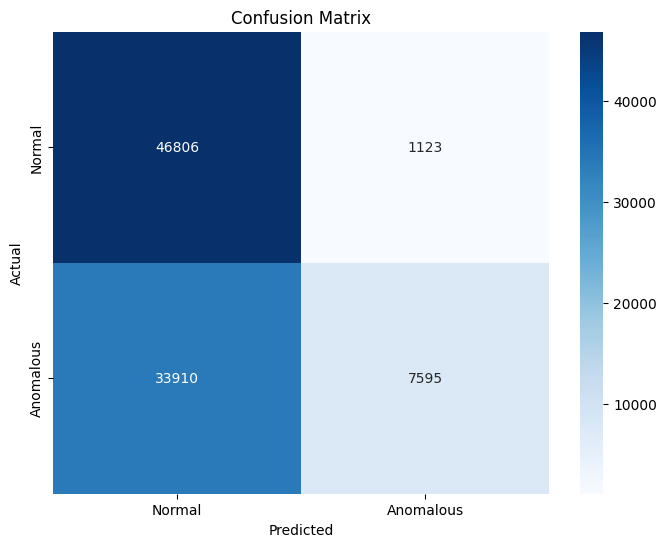

Precision: 0.87
Recall: 0.18
F1-Score: 0.30


In [15]:
# Accuracy score
accuracy = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:")
print(conf_matrix)

# Visualizing the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomalous'], yticklabels=['Normal', 'Anomalous'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


In [19]:
# Plot ROC Curve (if applicable)
from sklearn.metrics import roc_curve, auc

# Predict probabilities for ROC
y_pred_proba = best_svm_model.decision_function(X_test_lstm_features)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


NameError: name 'best_svm_model' is not defined

# Hyperparameter Tuning for SVM

In [16]:
# # Hyperparameter tuning for SVM using GridSearchCV
# param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01], 'kernel': ['linear', 'rbf']}
# grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
# grid_search.fit(X_train_lstm_features, y_train)

# # Best parameters
# print(f"Best Parameters: {grid_search.best_params_}")

# # Train with best parameters
# best_svm_model = grid_search.best_estimator_

# # Predict with the best model
# y_pred_best_svm = best_svm_model.predict(X_test_lstm_features)

# # Evaluate the best SVM model
# print("Optimized SVM Classification Report:")
# print(classification_report(y_test, y_pred_best_svm))


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=19.0min


In [19]:
# Hyperparameter tuning for SVM using GridSearchCV
param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid_search.fit(X_train_lstm_features, y_train)

# Best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Train with best parameters
best_svm_model = grid_search.best_estimator_

# Predict with the best model
y_pred_best_svm = best_svm_model.predict(X_test_lstm_features)

# Confusion Matrix and Classification Report
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomalous'], yticklabels=['Normal', 'Anomalous'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Now plot the confusion matrix using the predictions
plot_confusion_matrix(y_test, y_pred_best_svm)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_best_svm))


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=18.0min
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=17.6min
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=20.0min
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=20.9min
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=18.0min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=37.2min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=35.6min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=37.2min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=36.9min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=38.3min
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=17.9min
[CV] END ....................C=0.1, gamma=0.1, k